RAINSTORM - Created on Apr 18, 2024 - @author: Santiago D'hers

@author: Santiago D'hers

## Evaluate models
- This notebook will compare the performance of different trained models

#### Requirements:

- Models previously trained using RAINSTORM Create Models module
- A set of position files
- Labeled data for the position files (to train the model)

or

- Access to the example file **colabels.csv**, where we can find:
    - Position and labels for representative exploration events
    - It includes the labels of 5 viewers (so far)

In [1]:
import os
import pandas as pd
import rainstorm as rst

In [2]:
models_folder = 'C:/Users/dhers/Desktop/RAINSTORM/docs/models'
colabels = pd.read_csv(os.path.join(models_folder, 'colabels.csv'))

position = colabels.filter(regex='_x|_y').filter(regex='^(?!.*tail)').copy() # Extract positions, excluding tail-related columns

objects = ['obj']
bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body']
labelers_names = ['Marian', 'Agus', 'Santi', 'Guille', 'Myself']
labelers = pd.concat([colabels.filter(regex=name).copy() for name in labelers_names], axis=1) # Extract individual labelers' columns
geometric = colabels.filter(regex='Geometric').copy() # Extract geometric labels

past, future = 3, 3 # if you use a LSTM model, you can set the window size here
broad = 1.7 # using the same amount of frames, set how broad the window is (skipping frames)
broad_frames = rst.broaden(past, future, broad)
print(f'LSTM frame window: {broad_frames}')

use_model_date = '2024-11-29'

LSTM frame window: [-6, -3, -1, 0, 1, 3, 6]


In [3]:
# Create the chimera and the leave-one-out mean
chimera, loo_mean = rst.create_chimera_and_loo_mean(labelers) 
loo_mean = rst.smooth_columns(loo_mean, columns=['loo_mean'])

In [4]:
# Load the saved models
from keras.models import load_model
model_simple = load_model(os.path.join(models_folder, f'simple/simple_{use_model_date}.keras'))
model_wide = load_model(os.path.join(models_folder, f'wide/wide_{use_model_date}_7w.keras'))

from joblib import load
RF_model = load(os.path.join(models_folder, f'RF/model_RF_{use_model_date}.pkl'))

In [5]:
X_all = position.copy()

all_simple = rst.use_model(X_all, model_simple, objects=['obj'])
all_wide = rst.use_model(X_all, model_wide, objects=['obj'], reshaping = True, past=past, future=future, broad=broad)
all_RF = rst.use_model(X_all, RF_model, objects=['obj'])

5220/5220 [==============================] - 13s 2ms/step


c:\Users\dhers\miniconda3\envs\storm\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [6]:
zeros = loo_mean - loo_mean
random = loo_mean.sample(frac=1).reset_index(drop=True)

all_labelers = {'simple': all_simple, 'wide': all_wide, 'RF': all_RF,
                'chimera': chimera, 'mean': loo_mean,} #  'geometric': geometric, 'random': random, 'zeros': zeros}

for name in labelers_names:
    all_labelers[name] = colabels.filter(regex=name).copy()

# Verify the updated dictionary
print(all_labelers.keys())  # Check the keys to confirm the additions

dict_keys(['simple', 'wide', 'RF', 'chimera', 'mean', 'Marian', 'Agus', 'Santi', 'Guille', 'Myself'])


In [7]:
for name, df in all_labelers.items():
    print(f"{name}")
    rst.compare(df, loo_mean)

simple
Accuracy = 0.9826, Precision = 0.9825, Recall = 0.9826, F1 Score = 0.9826, Mean Squared Error = 0.0089, Mean Absolute Error = 0.0242, R-squared = 0.8310
wide
Accuracy = 0.9859, Precision = 0.9863, Recall = 0.9859, F1 Score = 0.9861, Mean Squared Error = 0.0073, Mean Absolute Error = 0.0188, R-squared = 0.8624
RF
Accuracy = 0.9873, Precision = 0.9874, Recall = 0.9873, F1 Score = 0.9873, Mean Squared Error = 0.0105, Mean Absolute Error = 0.0166, R-squared = 0.8009
chimera
Accuracy = 0.9775, Precision = 0.9774, Recall = 0.9775, F1 Score = 0.9775, Mean Squared Error = 0.0180, Mean Absolute Error = 0.0241, R-squared = 0.6597
mean
Accuracy = 1.0000, Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000, Mean Squared Error = 0.0000, Mean Absolute Error = 0.0000, R-squared = 1.0000
Marian
Accuracy = 0.9857, Precision = 0.9875, Recall = 0.9857, F1 Score = 0.9862, Mean Squared Error = 0.0126, Mean Absolute Error = 0.0186, R-squared = 0.7627
Agus
Accuracy = 0.9734, Precision = 0.9740, Rec

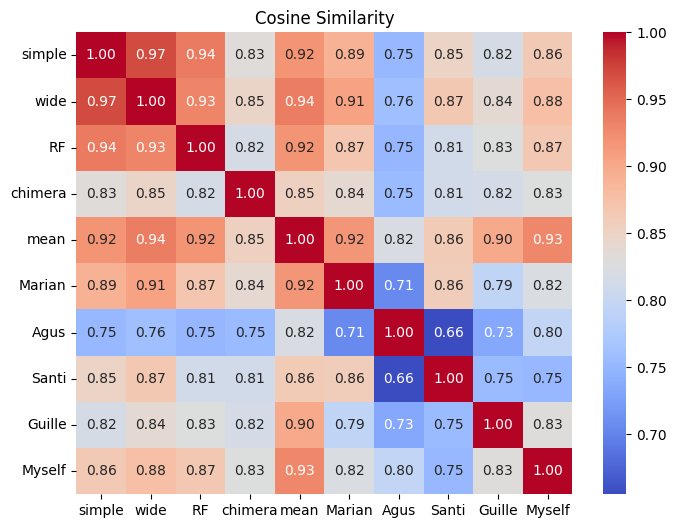

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Combine all columns into a single DataFrame
all_labelers_matrix = pd.DataFrame({name: df.iloc[:, 0] for name, df in all_labelers.items()})
cosine_sim = pd.DataFrame(cosine_similarity(all_labelers_matrix.T), index=all_labelers_matrix.columns, columns=all_labelers_matrix.columns)
plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim.astype(float), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cosine Similarity")
plt.show()


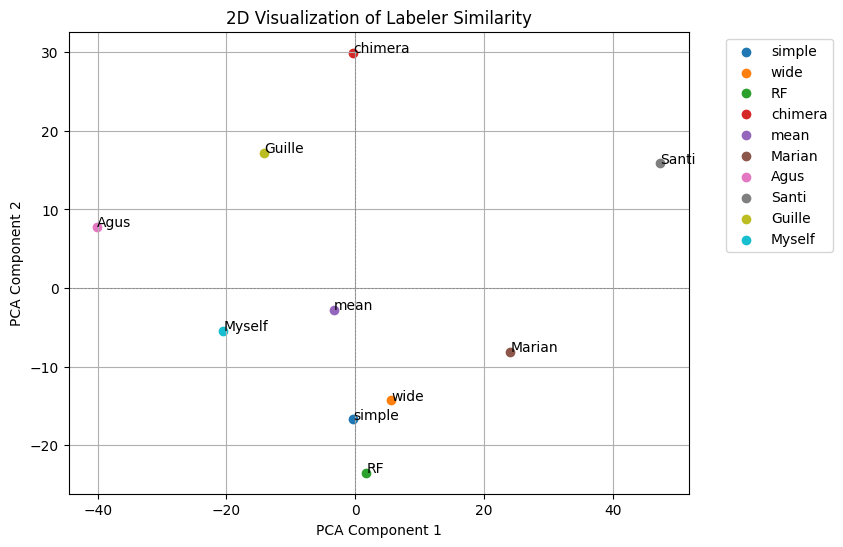

In [9]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(all_labelers_matrix.T)

# Plot
plt.figure(figsize=(8, 6))
for i, label in enumerate(all_labelers.keys()):
    plt.scatter(reduced_data[i, 0], reduced_data[i, 1], label=label)
    plt.text(reduced_data[i, 0] + 0.02, reduced_data[i, 1] + 0.02, label, fontsize=10)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D Visualization of Labeler Similarity')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

Now we can use the models in an example video

In [ ]:
# Prepare the dataset of a video we want to analyze and see
X_view = pd.read_csv(os.path.join(models_folder, 'example_video/Example_position.csv')).filter(regex='^(?!.*tail)')
video_path = os.path.join(models_folder, 'example_video/Example_video.mp4')

labels_A = pd.read_csv(os.path.join(models_folder, 'example_video/Example_Marian.csv'))
labels_B = pd.read_csv(os.path.join(models_folder, 'example_video/Example_Agus.csv'))
labels_C = pd.read_csv(os.path.join(models_folder, 'example_video/Example_Santi.csv'))
labels_D = pd.read_csv(os.path.join(models_folder, 'example_video/Example_Guille.csv'))
labels_E = pd.read_csv(os.path.join(models_folder, 'example_video/Example_Myself.csv'))

dfs_example = [labels_A, labels_B, labels_C, labels_D, labels_E]

# Calculate average labels
sum_df_example = pd.DataFrame()
for df in dfs_example:
    sum_df_example = sum_df_example.add(df, fill_value=0)
avrg_example = sum_df_example / len(dfs_example)

In [ ]:
autolabels_simple = rst.use_model(X_view, model_simple)
autolabels_wide = rst.use_model(X_view, model_wide, reshaping = True)
autolabels_RF = rst.use_model(X_view, RF_model)

In [ ]:
import plotly.graph_objects as go

plot_obj = "obj_1"

# Create a time axis (frame number divided by frame rate gives time in seconds)
time = np.arange(len(autolabels_simple[plot_obj])) / 25

# Create a figure
fig = go.Figure()

# Add traces for each label set
fig.add_trace(go.Scatter(x=time, y=[x * 1.025 for x in labels_A[plot_obj]], mode='markers', name='lblr_A', marker=dict(color='magenta')))
fig.add_trace(go.Scatter(x=time, y=[x * 1.05 for x in labels_B[plot_obj]], mode='markers', name='lblr_B', marker=dict(color='cyan')))
fig.add_trace(go.Scatter(x=time, y=[x * 1.075 for x in labels_C[plot_obj]], mode='markers', name='lblr_C', marker=dict(color='orange')))
fig.add_trace(go.Scatter(x=time, y=[x * 1.10 for x in labels_D[plot_obj]], mode='markers', name='lblr_D', marker=dict(color='purple')))
fig.add_trace(go.Scatter(x=time, y=[x * 1.125 for x in labels_E[plot_obj]], mode='markers', name='lblr_E', marker=dict(color='black')))

# fig.add_trace(go.Scatter(x=list(range(len(avrg_example["obj_1"]))), y=avrg_example["obj_1"], mode='lines', name='Average', line=dict(color='black')))

fig.add_trace(go.Scatter(x=time, y=autolabels_RF[plot_obj], mode='lines', name='RF', line=dict(color='gray', width=2)))
fig.add_trace(go.Scatter(x=time, y=autolabels_simple[plot_obj], mode='lines', name='Simple', line=dict(color='green', width=2)))
fig.add_trace(go.Scatter(x=time, y=autolabels_wide[plot_obj], mode='lines', name='Wide', line=dict(color='blue', width=2)))

# Add horizontal lines
fig.add_hline(y=0.5, line_dash="dash", line_color="black")

# Update layout
fig.update_layout(
title=dict(
        text=f'Performance of the models',
        x=0.5,
        y=0.95,
        xanchor='center',
        xref='paper'),
xaxis_title="Time (s)",
yaxis_title="Model output",
# legend=dict(yanchor="bottom", y=0.35, xanchor="left", x=0.2),  # Position the legend above the plot
# yaxis=dict(range=[None, 1.2]),
# xaxis=dict(range=[130, 144]),
margin=dict(t=60, b=20, l=20, r=20),
showlegend=True,
width=720,
height=480,
font=dict(size=18)
)

# Show the plot
fig.show()